# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [2]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to load the dataset
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

In [5]:
train_data = train['X']
test_data = test['X']
train_targets = train['y']
test_targets = test['y']

[6752, 11221, 11980, 14948, 18412, 31110, 33897, 46280, 59660, 68451]


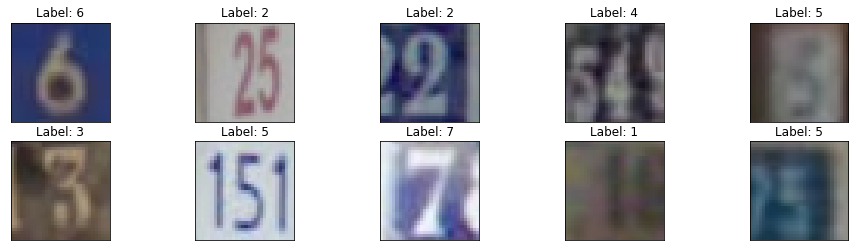

In [6]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
            
        ax.imshow(images[:,:,:,i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images(train_data[:,:,:,idxs],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)
    
plot_sample(10)

In [7]:
train_data_grey = train_data.mean(axis=2)
train_data_grey = np.expand_dims(train_data_grey,axis=2)
train_data_grey = np.moveaxis(train_data_grey, 3, 0)
test_data_grey = test_data.mean(axis=2)
test_data_grey = np.expand_dims(test_data_grey,axis=2)
test_data_grey = np.moveaxis(test_data_grey, 3, 0)
train_data_grey.shape

(73257, 32, 32, 1)

In [8]:
test_targets[test_targets == 10] = 0
train_targets[train_targets == 10] = 0

[17603, 20985, 21713, 35939, 42729, 44045, 60708, 61266, 66075, 68859]


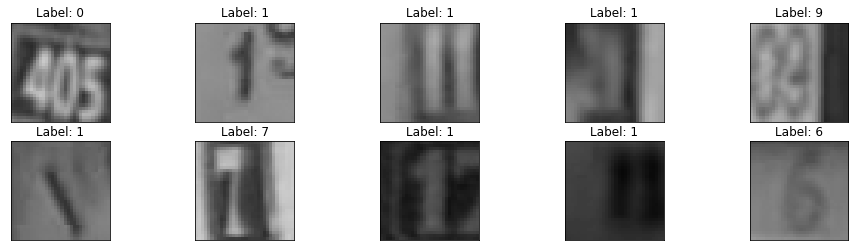

In [9]:
def plot_images_grey(images, nrows, ncols, cls_true):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
        ax.imshow(images[i,:,:,0],cmap='gray', vmin=0, vmax=255)
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample_grey(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images_grey(train_data_grey[idxs,:,:,:],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)

plot_sample_grey(10)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [48]:
def get_model_seq(input_shape):
    model = Sequential([
                Flatten(name='F1',input_shape=input_shape),
                Dense(128, activation='relu', 
                      name = 'D1'),
                Dense(128, activation='relu', name = 'D2'),
                Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D4R'),                
                Dense(10,  activation='softmax', name = 'SFTMX1')
    ])    
    return model

model_seq = get_model_seq(train_data_grey[0,:,:,:].shape)

In [49]:
model_seq.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
F1 (Flatten)                 (None, 1024)              0         
_________________________________________________________________
D1 (Dense)                   (None, 128)               131200    
_________________________________________________________________
D2 (Dense)                   (None, 128)               16512     
_________________________________________________________________
D4R (Dense)                  (None, 48)                6192      
_________________________________________________________________
SFTMX1 (Dense)               (None, 10)                490       
Total params: 154,394
Trainable params: 154,394
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_seq.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [51]:
callbacks_seq = [ EarlyStopping(monitor='val_sparse_categorical_accuracy',
                           mode='max',
                           patience=3),
              ModelCheckpoint(  filepath="checkpoint_best_seq",
                                save_weights_only=True,
                                save_freq='epoch',
                                monitor='val_sparse_categorical_accuracy',
                                save_best_only=True,
                                verbose=2             )  
            ]

In [52]:
history_seq = model_seq.fit(  train_data_grey, 
                      train_targets,
                      epochs=30, 
                      validation_data=(test_data_grey, test_targets),
                      callbacks=callbacks_seq,
                      batch_size=512)

Train on 73257 samples, validate on 26032 samples
Epoch 1/30
73216/73257 [============================>.] - ETA: 0s - loss: 18.7504 - sparse_categorical_accuracy: 0.1177
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.17279, saving model to checkpoint_best_seq
73257/73257 [==============================] - 14s 185us/sample - loss: 18.7444 - sparse_categorical_accuracy: 0.1177 - val_loss: 8.6643 - val_sparse_categorical_accuracy: 0.1728
Epoch 2/30
73216/73257 [============================>.] - ETA: 0s - loss: 7.2427 - sparse_categorical_accuracy: 0.1271
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.17279
73257/73257 [==============================] - 11s 153us/sample - loss: 7.2413 - sparse_categorical_accuracy: 0.1271 - val_loss: 5.8247 - val_sparse_categorical_accuracy: 0.1205
Epoch 3/30
73216/73257 [============================>.] - ETA: 0s - loss: 5.9052 - sparse_categorical_accuracy: 0.1380
Epoch 00003: val_sparse_categorical_accuracy impr

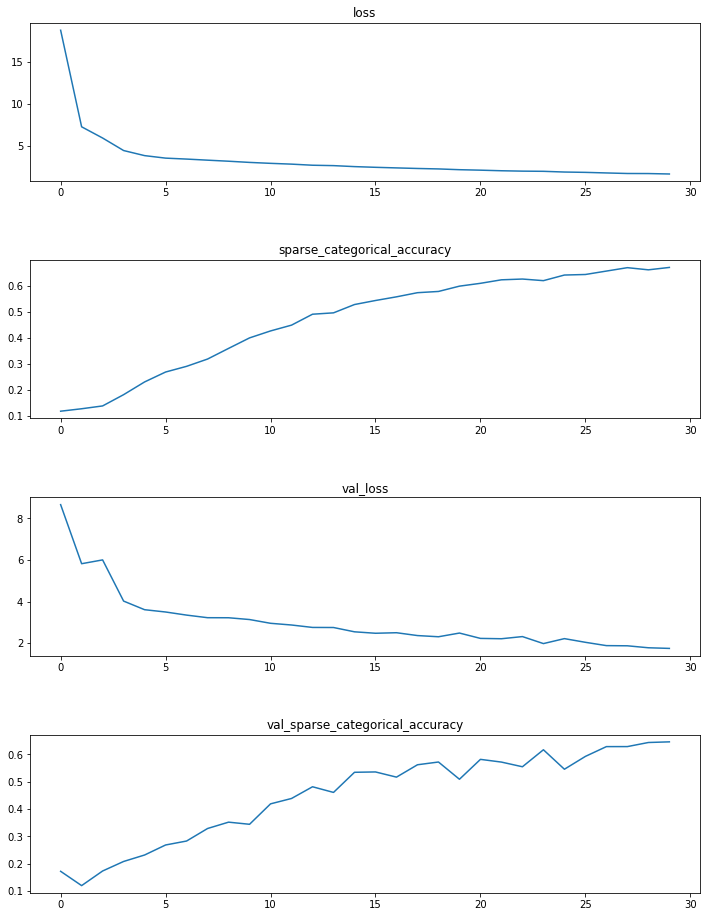

In [53]:
def history_of_fit(history_df):
    fig, axes = plt.subplots(len(history_df.columns.values), 1, figsize=(12, 16))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i in range(len(history_df.columns.values)):
        column_name = history_df.columns.values[i]
        axes[i].plot(history_df.index, history_df[column_name])
        axes[i].set_title(column_name)

df_seq = pd.DataFrame(history_seq.history)
history_of_fit(df_seq)

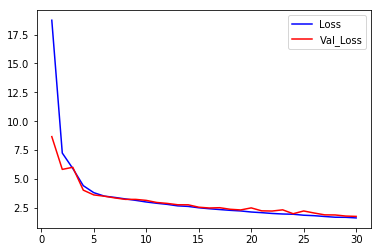

In [56]:
x = range(1, df_seq.shape[0]+1)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(x,df_seq['loss'],c='b',label='Loss')
ax.plot(x,df_seq['val_loss'],c='r',label='Val_Loss')
plt.legend(loc=1)
plt.show()

In [57]:
model_seq.save("saved_seq_model_t1.h5")

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [26]:
def get_cnn_model(input_shape):
    return Sequential([
        Conv2D(16, kernel_size=3, padding='same', 
                           activation='relu',
                           input_shape=input_shape),
        MaxPooling2D((2, 2), padding ='same'),
        BatchNormalization(),
        Conv2D(16, (3, 3), padding='same', 
                        activation='relu'),
        Dropout(0.3),
        MaxPooling2D((2, 2), padding ='same'),
        Flatten(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.4),    
        Dense(10,  activation='softmax')        
    ])

print(train_data_grey[0,:,:,:].shape == train_data_grey.shape[1:])
print(train_data_grey.shape[1:])

True
(32, 32, 1)


In [27]:
cnn_model = get_cnn_model(train_data_grey[0,:,:,:].shape)
cnn_model.summary()   
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)             

In [28]:
cnn_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [29]:
callbacks_cnn = [ EarlyStopping(monitor='val_sparse_categorical_accuracy',
                           mode='max',
                           patience=3),
              ModelCheckpoint(  filepath="checkpoint_best_cnn",
                                save_weights_only=True,
                                save_freq='epoch',
                                monitor='val_sparse_categorical_accuracy',
                                save_best_only=True,
                                verbose=1             )  
            ]

In [30]:
history_cnn = cnn_model.fit(  train_data_grey, 
                      train_targets,
                      epochs=30, 
                      validation_data=(test_data_grey, test_targets),
                      callbacks=callbacks_cnn,
                      batch_size=128)

Train on 73257 samples, validate on 26032 samples
Epoch 1/30
73216/73257 [============================>.] - ETA: 0s - loss: 1.9503 - sparse_categorical_accuracy: 0.2933
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.66587, saving model to checkpoint_best_cnn
73257/73257 [==============================] - 245s 3ms/sample - loss: 1.9498 - sparse_categorical_accuracy: 0.2935 - val_loss: 1.1318 - val_sparse_categorical_accuracy: 0.6659
Epoch 2/30
73216/73257 [============================>.] - ETA: 0s - loss: 1.1356 - sparse_categorical_accuracy: 0.6206
Epoch 00002: val_sparse_categorical_accuracy improved from 0.66587 to 0.78945, saving model to checkpoint_best_cnn
73257/73257 [==============================] - 243s 3ms/sample - loss: 1.1354 - sparse_categorical_accuracy: 0.6207 - val_loss: 0.8020 - val_sparse_categorical_accuracy: 0.7895
Epoch 3/30
73216/73257 [============================>.] - ETA: 0s - loss: 0.9098 - sparse_categorical_accuracy: 0.7062
Epoch 00003:

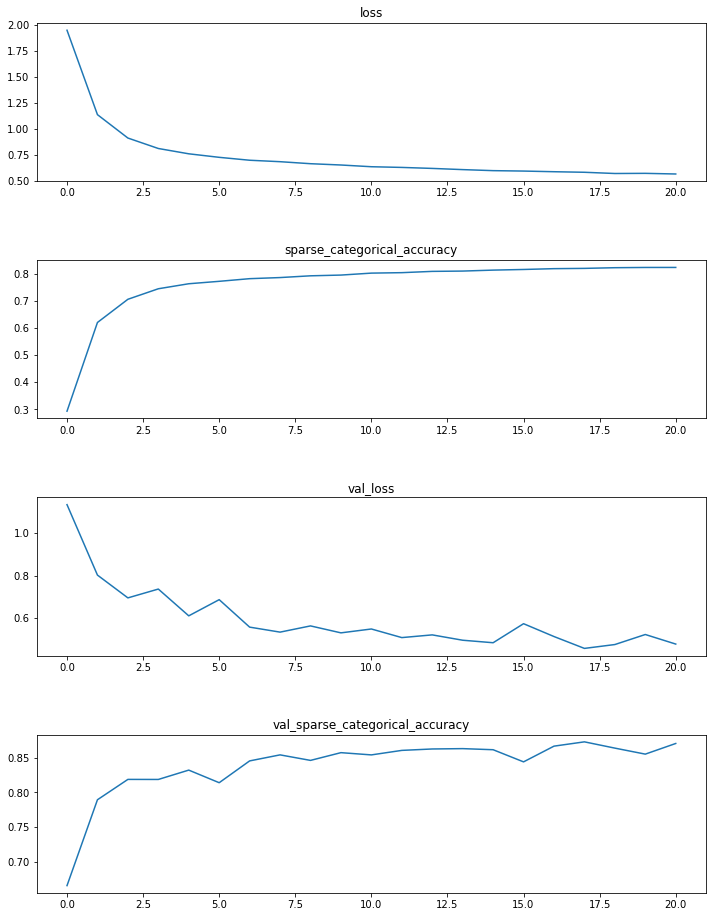

In [31]:
def history_of_fit(history_df):
    fig, axes = plt.subplots(len(history_df.columns.values), 1, figsize=(12, 16))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i in range(len(history_df.columns.values)):
        column_name = history_df.columns.values[i]
        axes[i].plot(history_df.index, history_df[column_name])
        axes[i].set_title(column_name)

df_cnn = pd.DataFrame(history_cnn.history)
history_of_fit(df_cnn)


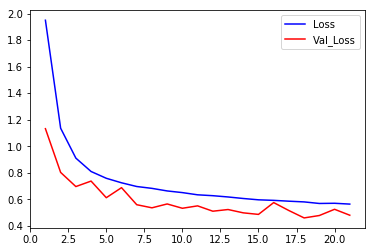

In [32]:
x = range(1, df_cnn.shape[0]+1)
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(x,df_cnn['loss'],c='b',label='Loss')
ax.plot(x,df_cnn['val_loss'],c='r',label='Val_Loss')
plt.legend(loc=1)
plt.show()

In [23]:
cnn_model.save("saved_cnn_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_cnn_model/assets


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [33]:
cnn_model = tf.keras.models.load_model("saved_cnn_model")
cnn_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])
# cnn_model = get_cnn_model(train_data_grey[0,:,:,:].shape)
# model_cnn.load_weights("checkpoint_best_cnn") # ValueError: Shapes (3, 3, 73257, 16) and (3, 3, 1, 16) are incompatible

In [38]:
num_sample=5
idxs = sorted(random.sample(range(test_targets.shape[0]),num_sample))
print(idxs)

[3052, 5958, 17065, 17926, 21677]


In [39]:
predicted_cnn = cnn_model.predict(test_data_grey[idxs,:,:,:])
cls_true = test_targets[idxs]
predicted_labels_cnn = np.apply_along_axis(np.argmax,1,predicted_cnn)
predicted_labels_cnn

array([4, 1, 2, 9, 9])

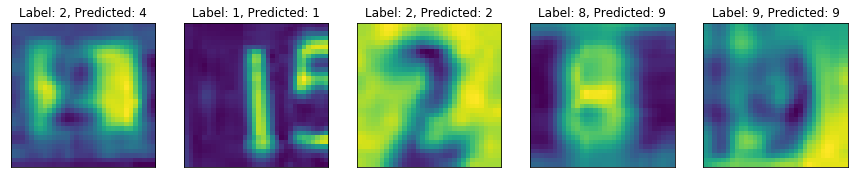

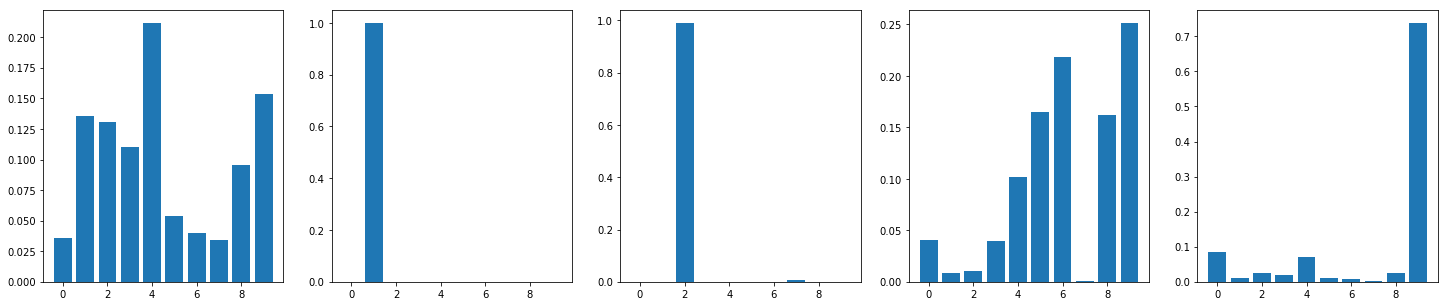

In [40]:
images = test_data_grey[idxs,:,:,:]
fig, axes = plt.subplots(1, num_sample, figsize=(num_sample*3, 16))
for i, ax in enumerate(axes.flat): 
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = f"Label: {true_number}, Predicted: {predicted_labels_cnn[i]}"       
        ax.imshow(images[i,:,:,0])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
fig, axes = plt.subplots(1, num_sample, figsize=(5*num_sample, 5))
for i, ax in enumerate(axes.flat): 
    ax.bar(np.arange(0,len(predicted_cnn[i])),predicted_cnn[i])        
        

In [58]:
# model_seq = get_model_seq(train_data[0,:,:,:].shape)
# model_seq.load_weights("checkpoint_best_seq")
model_seq_dens = tf.keras.models.load_model("saved_seq_model_t1.h5")

In [59]:
predicted_seq = model_seq_dens.predict(test_data_grey[idxs,:,:,:])
cls_true = test_targets[idxs]
predicted_labels_seq = np.apply_along_axis(np.argmax,1,predicted_seq)
predicted_labels_seq


array([9, 1, 2, 8, 0])

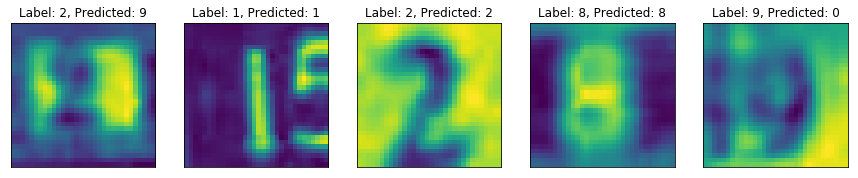

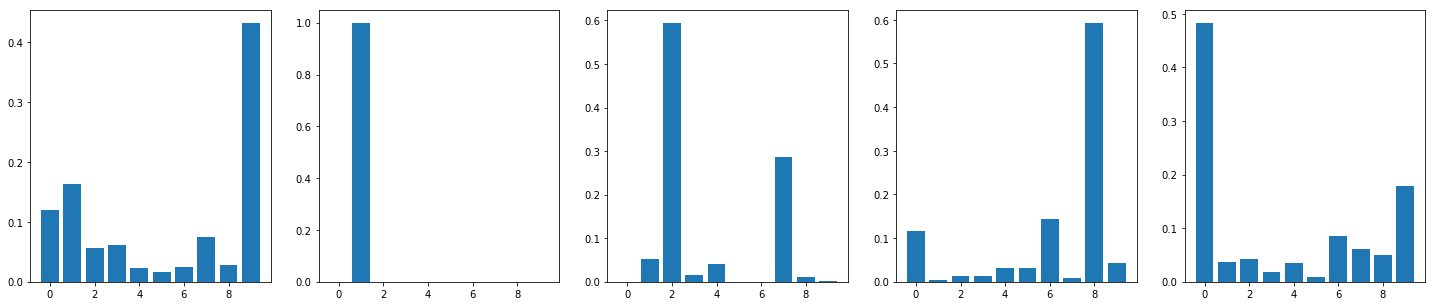

In [60]:
images = test_data_grey[idxs,:,:,:]
fig, axes = plt.subplots(1, num_sample, figsize=(num_sample*3, 16))
for i, ax in enumerate(axes.flat): 
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = f"Label: {true_number}, Predicted: {predicted_labels_seq[i]}"       
        ax.imshow(images[i,:,:,0])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])
fig, axes = plt.subplots(1, num_sample, figsize=(5*num_sample, 5))
for i, ax in enumerate(axes.flat): 
    ax.bar(np.arange(0,len(predicted_seq[i])),predicted_seq[i])        
        
        